In [23]:
!which python3

/Users/mahat/Desktop/Dev/JB_Project/sentiment-analysis/.venv/bin/python3


In [24]:
import numpy as np
import pandas as pd
import datasets
import seaborn as sns
import matplotlib.pyplot as plt

# conf


In [ ]:
# download data
from datasets import load_dataset,load_from_disk
ds = load_dataset('ajaykarthick/imdb-movie-reviews')
ds_train_subset = ds['train'].shuffle(seed=42).select(range(0,5120))

#### Data Sample Observation

In [26]:
ds_train_subset['review'][0:10]

["This has to be one of the most awfully scripted films I've ever seen. It's basically a remake of The Beast From 20,000 Fathoms (1953), but done with your standard snake-like puppet-monster instead of a sleek Ray Harryhausen creation. Combine the plot of that classic monster movie with the production qualities and acting level of The Creeping Terror and you have an idea of what this movie is like.<br /><br />The movie is dubbed, although by the original actors (I think that the movie was originally dubbed in Italian for that countries audiences, then redubbed for US release), which just makes the movie seem weird...the sounds, like in a Japanese monster movie, just don't quite match properly to the action on the screen, even if the actors' lips are moving properly.<br /><br />Poor Ray Milland...he's certainly come a long way down from The Lost Weekend or Dial M for Murder or any of the number of excellent movies he was in. Add this to his other sci-fi travesties (Panic in the Year Zer

In [27]:
ds_train_subset['label'][0:10]

[1, 1, 1, 0, 1, 0, 1, 1, 0, 0]

In [28]:
type(ds_train_subset)

datasets.arrow_dataset.Dataset

#### Label count check after sampling

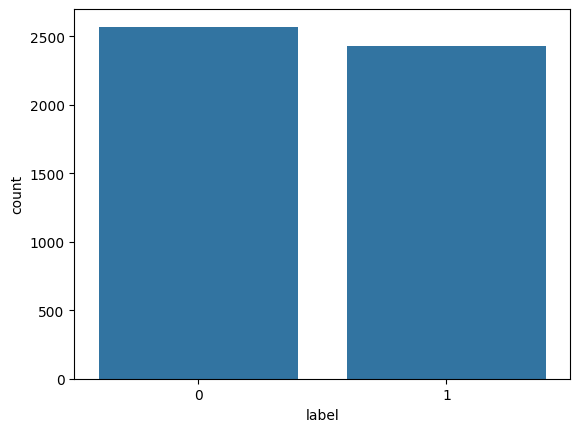

In [29]:
# countplot
ax = sns.countplot({'label': ds_train_subset['label']}, x='label')

#### Text Processing Pipeline

In [30]:
# basic text filter
import re
import string
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download("punkt")
nltk.download("wordnet")
nltk.download('punkt_tab')
wnl = WordNetLemmatizer()
TAG_RE = re.compile(r'<[^>]+>')

def basic_text_filter(text):
    # remove html text 
    cText = re.sub(TAG_RE, '', text.lower())
    # remove punctiotion
    cText = cText.translate(str.maketrans("", "", string.punctuation))
    # stemming using nltk
    # remove stop words
    stop_words = set(stopwords.words('english'))
    cText = [w for w in word_tokenize(cText) if not w.lower() in stop_words]
    # return cleaned version
    return " ".join(wnl.lemmatize(word, pos="v") for word in cText)
basic_text_filter(ds_train_subset['review'][4])

[nltk_data] Downloading package punkt to /Users/mahat/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/mahat/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/mahat/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


'tell truth ’ bite stun see positive review many people also main reason actually decide see movie see really disappoint come guy love genre moviei ’ surprise movie completely – like kid ’ movie nudity absolutely reason involve little children curse swear ’ righteous really go far accountsynopsis story two guy get send big brother program reckless behavior meet one kid boob obsession medieval freakjust name self really connect story role model anything serve time do story predictable though expect humor lame ’ already see character play mc lovin ’ many movies like sasquatch gang think laugh thrice almost fell sleepwell cast alright one produce screenplay act soso expect ’ watch type movie direction one expect guy bring us wet hot american summer movie also suck somehow always manage bring star attract horrendous movieanyway felt total riff completely waste time naked scenes seem best part movie ’ really see point recommend anyonepros elizabeth bank two topless scenescons funny dreadful

In [31]:
# append length to dataset
ds_train_subset = ds_train_subset.map(lambda x: {'length': len(x['review'])}).map(lambda x: {'clean_text':basic_text_filter(x['review'])})
one_examples = ds_train_subset.filter(lambda x: x['label'] == 1)
zero_examples = ds_train_subset.filter(lambda x: x['label'] == 0)

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [32]:
def plot_length_stats(data,ax,title):
    if type(data) == list:
        data = {'length': data}
    ax = sns.histplot(data,ax=ax)
    ax.set_title(title)
    # basic stats
    text_template = f'mean: {np.mean(data['length']):.2f} \nmax: {np.max(data['length']):.2f} \nmedian: {np.median(data['length']):.2f}\nstd: {np.std(data['length']):.2f}'
    ax.text(0.75, 0.75, text_template, size=10, color='black',horizontalalignment='right',verticalalignment='center',transform=ax.transAxes)
    return ax

#### WordClouds

In [33]:
# word clouds
from wordcloud import WordCloud, STOPWORDS
def generate_wc(text,title=""):
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(background_color="white",max_words=2000,stopwords=stopwords).generate(text)
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.title(title)
    plt.axis("off")


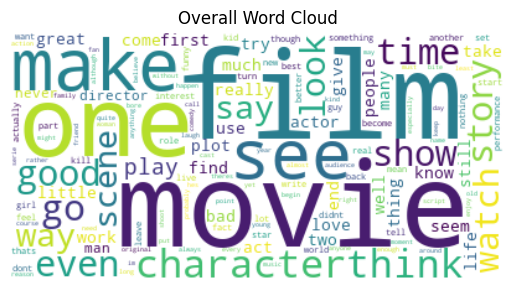

In [34]:
# Overall 
generate_wc(" ".join(ds_train_subset['clean_text']),title="Overall Word Cloud")

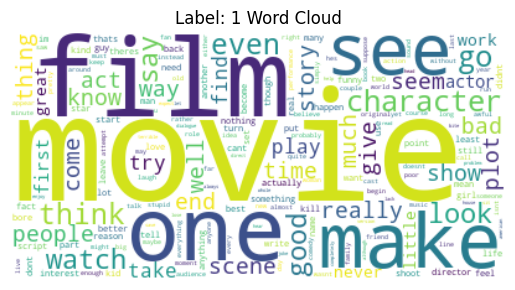

In [35]:
# positive cases
generate_wc(" ".join(one_examples['clean_text']),"Label: 1 Word Cloud")


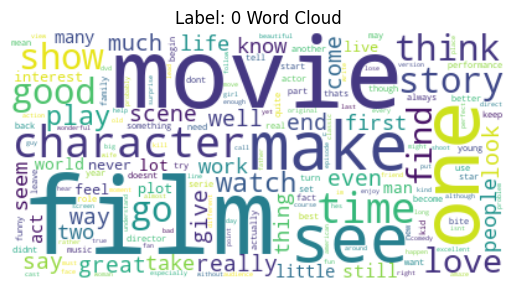

In [36]:
# negative cases
generate_wc(" ".join(zero_examples['clean_text']),"Label: 0 Word Cloud")

### Length difference between 0 and 1 Labels

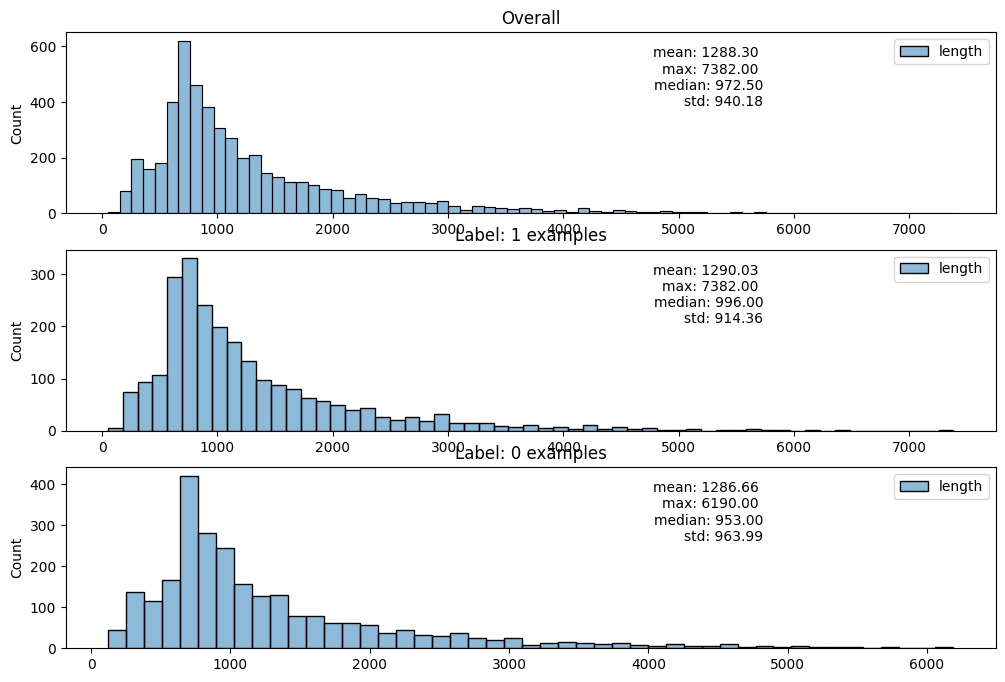

In [59]:
fig, axs = plt.subplots(3,figsize=(12,8))
plot_length_stats(ds_train_subset['length'],axs[0],'Overall')
plot_length_stats(one_examples['length'],axs[1],'Label: 1 examples')
plot_length_stats(zero_examples['length'],axs[2],'Label: 0 examples')
fig.savefig('../docs/review_lengths.png')

#### Word Frequency

In [38]:
# generate word frequency
from functools import reduce
from nltk.probability import FreqDist
from nltk.corpus import stopwords
nltk.download('stopwords')
def generate_wf(text_list,top_k=100,normalize=True,title='',ax=None):
    text = " ".join(text_list)
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    non_stop_tokens = [w for w in word_tokens if not w.lower() in stop_words]
    fq = FreqDist(word.lower() for word in non_stop_tokens)
    #fq.plot()
    data = pd.Series(dict(fq.most_common(top_k))).rename('words')
    if normalize:
        total = reduce(lambda a,b: a + b, [e[1] for e in fq.items()])
        data = data / total
    ax = sns.barplot(y=data.index,x=data.values,orient='h',ax=ax)
    ax.set_title(title)
    return ax

[nltk_data] Downloading package stopwords to /Users/mahat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


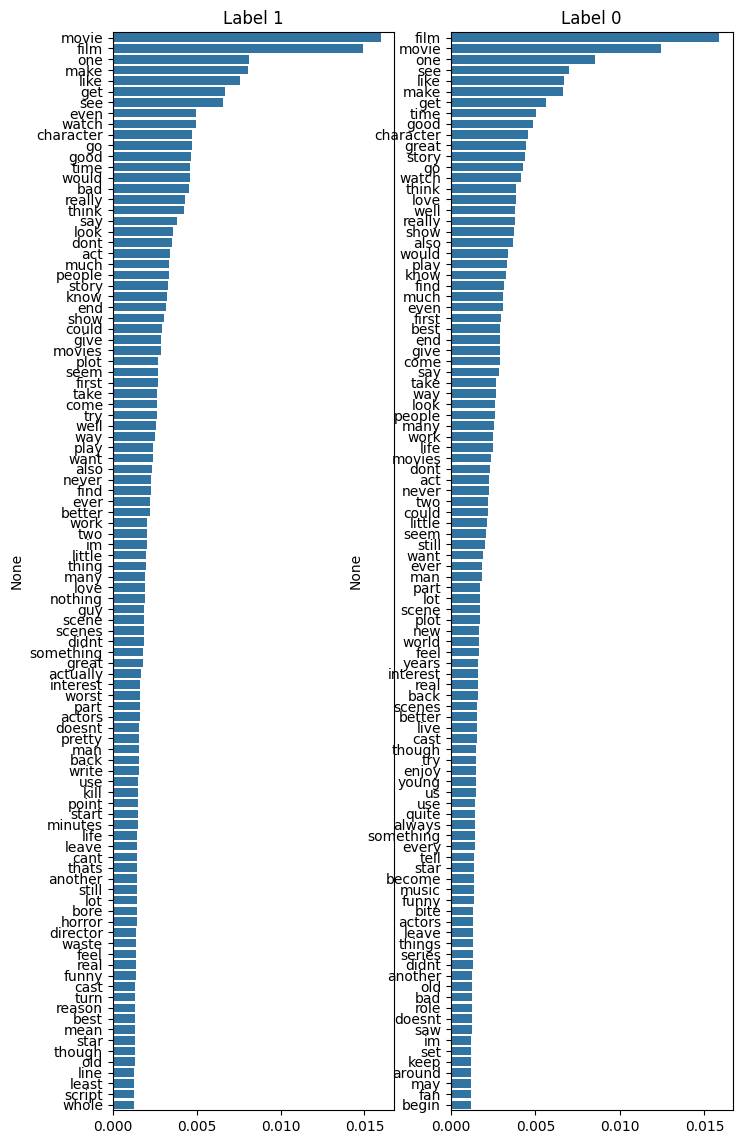

In [60]:
# positive vs negative word freq
fig,axs = plt.subplots(1,2,figsize=(8,14))
generate_wf(one_examples['clean_text'],title='Label 1',ax=axs[0])
generate_wf(zero_examples['clean_text'],title='Label 0',ax=axs[1])
fig.savefig('../docs/word_freq.png')

#### text clustering using sBert

In [ ]:

# sentence bert
# clustering
from sentence_transformers import SentenceTransformer
from sklearn.cluster import DBSCAN
from tqdm import tqdm
from umap import UMAP
import textwrap

# encode text
def embed(model, texts,embed_batch_size=64):
    # remove tags before clustering
    cTexts = [re.sub(TAG_RE, '', text.lower()) for text in texts]
    embeddings = model.encode(
        cTexts,
        batch_size=embed_batch_size,
        show_progress_bar=True,
        convert_to_numpy=True,
        normalize_embeddings=True,
    )
    return embeddings

def project(embeddings):
    mapper = UMAP(n_components=2, metric="cosine").fit(
        embeddings
    )
    return mapper.embedding_, mapper

def cluster(projections,dbscan_eps,dbscan_min_samples,dbscan_n_jobs=16):
    print(
        f"Using DBSCAN (eps, nim_samples)=({dbscan_eps}, {dbscan_min_samples})"
    )
    clustering = DBSCAN(
        eps=dbscan_eps,
        min_samples=dbscan_min_samples,
        n_jobs=dbscan_n_jobs,
    ).fit(projections)

    return clustering.labels_

def plot_projections(projections,labels=None,texts=None,title=''):
    df = pd.DataFrame(
            data={
                "X": projections[:, 0],
                "Y": projections[:, 1],
            }
        )
    if labels is not None:
        df['labels'] = labels
        df["color"] = df["labels"].apply(lambda x: "C0" if x==-1 else f"C{(x%9)+1}")
    else:
        df['color'] = "blue"
        df['labels'] = 1
    if texts:
        df['content'] = [textwrap.fill(txt[:1024], 64) for txt in texts]
        
    fig, ax = plt.subplots(figsize=(12, 8)) # , dpi=300

    df.plot(
        kind="scatter",
        x="X",
        y="Y",
        # c="labels",
        # s=0.75,
        alpha=0.8,
        linewidth=0,
        color=df["color"],
        ax=ax,
        colorbar=False,
        title=title,
        )
    return fig


In [41]:
ds_train_subset

Dataset({
    features: ['review', 'label', 'length', 'clean_text'],
    num_rows: 5000
})

In [42]:
embed_model = SentenceTransformer("all-MiniLM-L6-v2", device="mps")

In [43]:
# embeddings
embeddings = embed(model=embed_model,texts=ds_train_subset['review']) # [0:2048]
# projections
projections, mapper = project(embeddings)

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

/Users/mahat/Desktop/Dev/JB_Project/sentiment-analysis/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


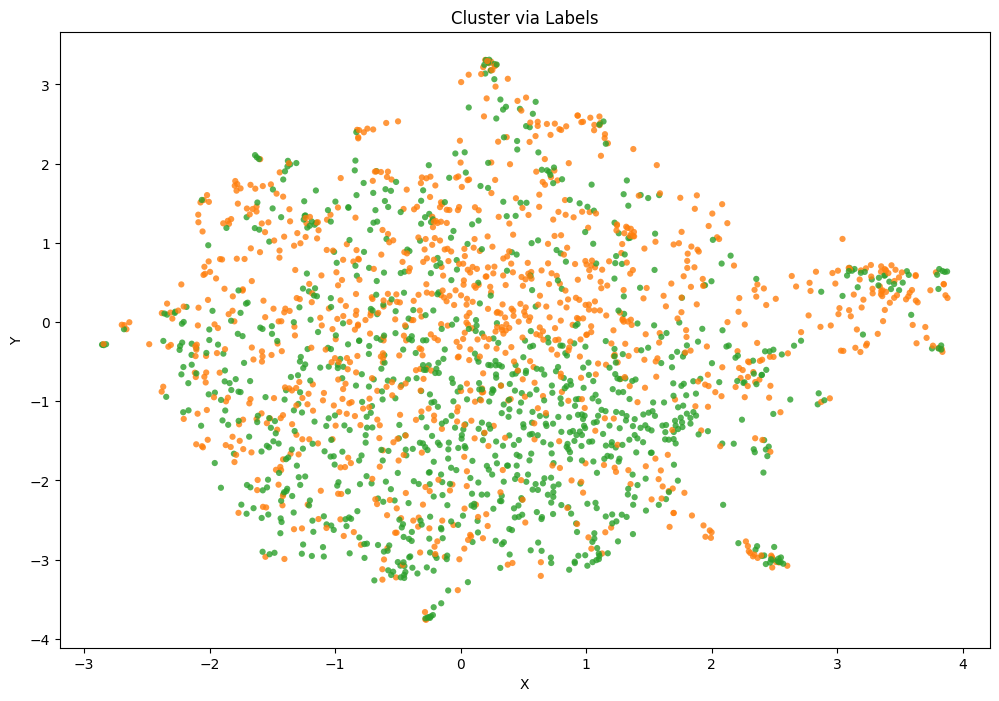

In [ ]:
# plot projections
fig = plot_projections(projections,labels=ds_train_subset['label'],title="Cluster via Labels") # [0:2048]
fig.savefig('../docs/text_cluster_label.png')


Using DBSCAN (eps, nim_samples)=(0.3, 15)


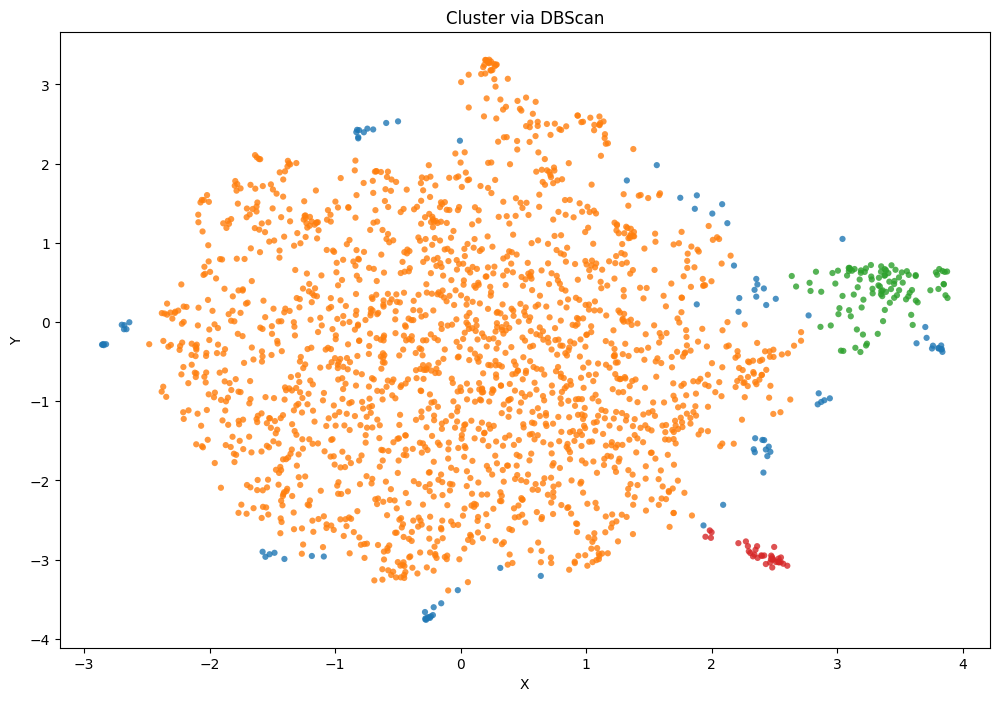

In [55]:
# cluster 
labels = cluster(projections, dbscan_eps=0.3,dbscan_min_samples=15)
fig = plot_projections(projections,labels=labels,title="Cluster via DBScan")
fig.savefig('../docs/text_cluster_dbscan.png')

In [57]:
# cluster sizes
unique, counts = np.unique(labels, return_counts=True)
[{int(u):int(c)} for u,c in zip(unique, counts)]

[{-1: 91}, {0: 1822}, {1: 100}, {2: 35}]

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

/Users/mahat/Desktop/Dev/JB_Project/sentiment-analysis/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


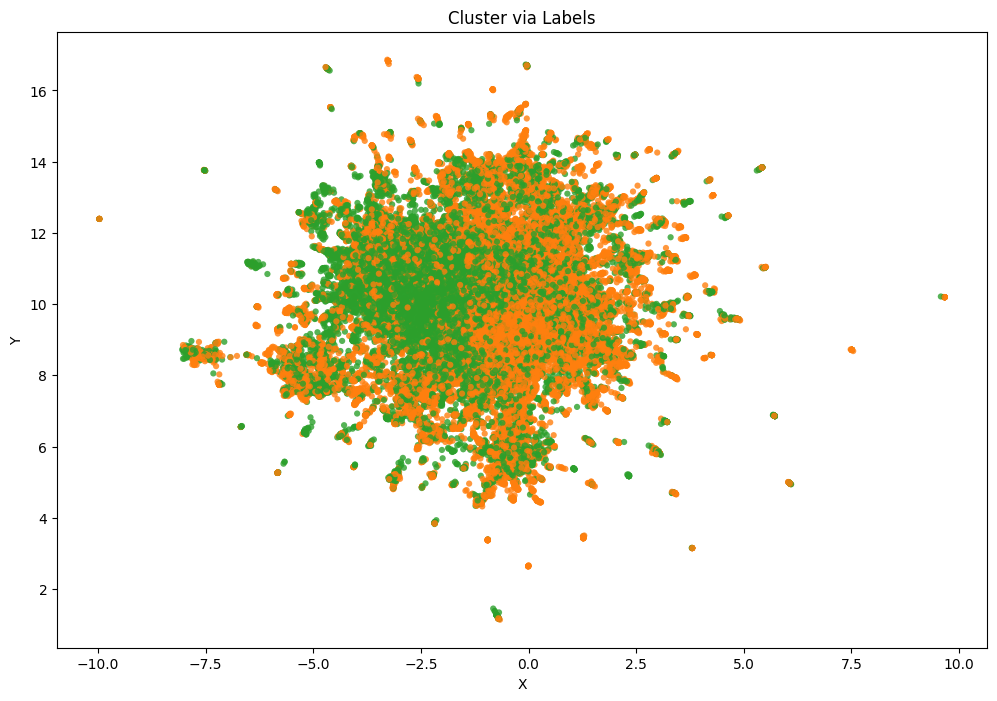

In [70]:
# embeddings
embeddings = embed(model=embed_model,texts=ds['train']['review']) # [0:2048]
# projections
projections, mapper = project(embeddings)
fig = plot_projections(projections,labels=ds['train']['label'],title="Cluster via Labels")

Using DBSCAN (eps, nim_samples)=(0.3, 150)


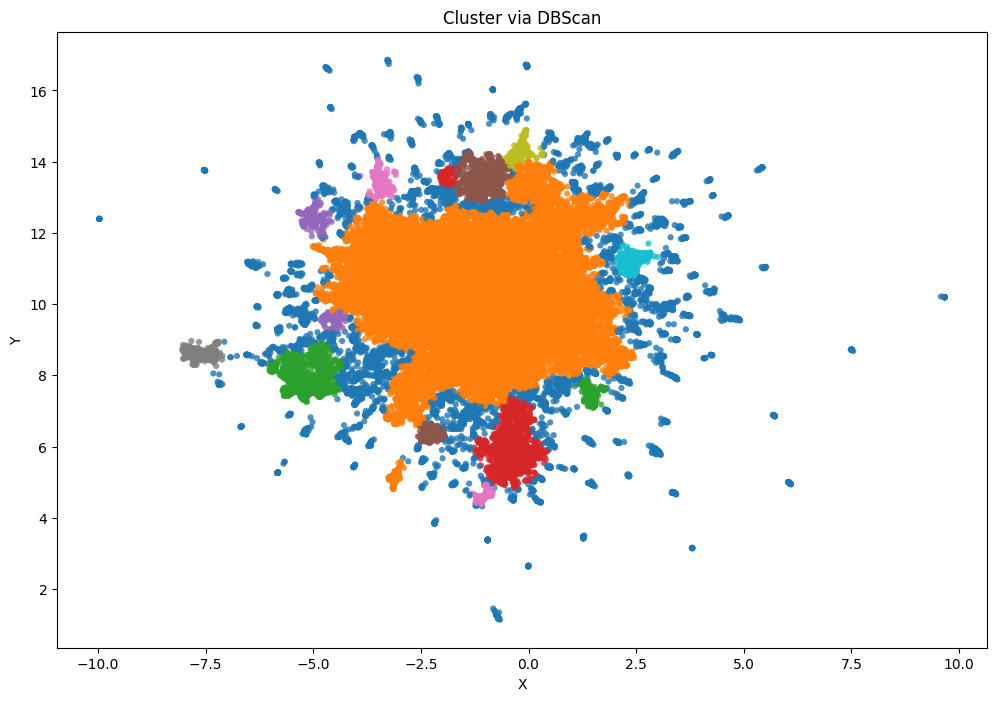

In [76]:
labels = cluster(projections, dbscan_eps=0.3,dbscan_min_samples=150)
fig = plot_projections(projections,labels=labels,title="Cluster via DBScan")

In [77]:
unique, counts = np.unique(labels, return_counts=True)
[{int(u):int(c)} for u,c in zip(unique, counts)]
# bar plots for cluster ids


[{-1: 6883},
 {0: 26507},
 {1: 1146},
 {2: 1660},
 {3: 301},
 {4: 842},
 {5: 362},
 {6: 609},
 {7: 275},
 {8: 380},
 {9: 189},
 {10: 225},
 {11: 121},
 {12: 167},
 {13: 181},
 {14: 152}]

Text(0.5, 1.0, '# examples in cluster')

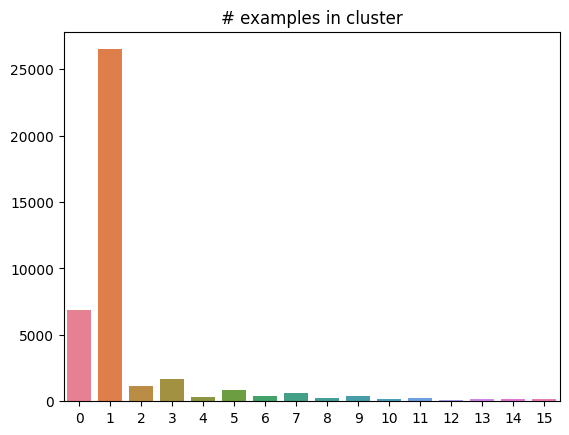

In [120]:
ax = sns.barplot(data=[{int(u):int(c)} for u,c in zip(unique, counts)])
ax.set_title('# examples in cluster')

In [121]:
# append cluster labels to ds
train_ds = ds['train'].add_column('cluster_label',labels).add_column('index',np.arange(0,len(ds['train'])))
train_ds.save_to_disk('../data/train_ds.hf')

Saving the dataset (0/1 shards):   0%|          | 0/40000 [00:00<?, ? examples/s]

In [122]:
tmp_ds = train_ds.map(lambda x: {'group': str(x['label']) + '_' + str(x['cluster_label'])})

In [126]:
# stratified sampling
def stratified_sampling(dataset,n_samples_small, n_samples_big):
    assert n_samples_small < n_samples_big
    # does stratified sampling on label + cluster_label and returns validation(small & big) and in_context sets (small & big)
    grouped_ds = dataset.map(lambda x: {'group': str(x['label']) + '_' + str(x['cluster_label'])})
    big_valid_chunks = []
    big_incontext_chunks = []
    small_valid_chunks = []
    small_incontext_chuncks = []
    for u in np.unique(grouped_ds['group']):
        # filter dataset and select
        dataset_sub = grouped_ds.filter(lambda x: x['group'] == u).shuffle(seed=42).select(range(0,n_samples_big*2))
        # half goes to validation
        big_valid_chunks.append(dataset_sub.select(range(0,n_samples_big)))
        # half goes to incontext
        big_incontext_chunks.append(dataset_sub.select(range(n_samples_big, n_samples_big*2)))
        # checking size of chunks 
        assert len(big_incontext_chunks[-1]) == n_samples_big
        assert len(big_valid_chunks[-1]) == n_samples_big

    # split to small for valid and incontext chunks
    mini_valid_chunks = [c.shuffle(seed=42).select(range(0,2)) for c in big_valid_chunks]
    small_valid_chunks = [c.shuffle(seed=42).select(range(0,n_samples_small)) for c in big_valid_chunks]
    small_incontext_chuncks = [c.shuffle(seed=42).select(range(0,n_samples_small)) for c in big_incontext_chunks]
    # merge and write
    mini_valid_ds = datasets.concatenate_datasets(mini_valid_chunks) 
    big_valid_ds = datasets.concatenate_datasets(big_valid_chunks)
    big_incotext_ds = datasets.concatenate_datasets(big_incontext_chunks)
    small_valid_ds = datasets.concatenate_datasets(small_valid_chunks)
    small_incontext_ds = datasets.concatenate_datasets(small_incontext_chuncks)

    return mini_valid_ds, big_valid_ds, big_incotext_ds, small_valid_ds, small_incontext_ds

mv, bv, bi, sv, si = stratified_sampling(train_ds,4,16)

mv.save_to_disk('../data/valid_mini.hf')
bv.save_to_disk('../data/valid_big.hf')
bi.save_to_disk('../data/incontext_big.hf')
sv.save_to_disk('../data/valid_small.hf')
si.save_to_disk('../data/incontext_small.hf')
print(len(mv), len(bv),len(bi),len(sv),len(si))



Saving the dataset (0/1 shards):   0%|          | 0/64 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/512 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/512 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/128 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/128 [00:00<?, ? examples/s]

64 512 512 128 128


In [128]:
si

Dataset({
    features: ['review', 'label', 'cluster_label', 'index', 'group'],
    num_rows: 128
})

In [130]:
ds['test'].shuffle(42).select(range(0,256)).save_to_disk('../data/test.hf')

Saving the dataset (0/1 shards):   0%|          | 0/256 [00:00<?, ? examples/s]